# PROJET: Clustering et routage dans un essaim de nano-satellites

## On repartira le traitement en trois principaux objectifs

###   1- Caractérisation de la dynamique de l'essaim 
a) Identifier les cliques (groupes de satellites connectés entre eux)

b) Composantes connenexes (sous-réseaux isolés)

c) temps inter contact (Durrée moyenne entre deux connexions)

###   2- Proposition de méthoders de clustering ( à Explorer ...)
###   3- Etudes et comparaison des algorithmes proposés

### Avant tout il faut faire executer la ligne ci-dessous 
pip install networkx
ou
!pip install networkx

Ensuite, il faut relancer le noyau

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from swarm_sim import Swarm, Node   ## On importe les fonction du fichier swarm_sim.py
from tqdm import tqdm

## Caractérisation de la dynamique de l'essai

On se servira essentiellement des fonctions fournies dans le fichier swarm_sim.py

In [8]:
# Chargement des données comme dans le papier
def load_swarm_data(path, num_nodes=100, duration=2000):
    df = pd.read_csv(path, header=None)
    swarm = Swarm(connection_range=30000)  # 30km comme dans le papier
    
    # Création des noeuds avec des IDs entiers simples
    nodes = [Node(id=i) for i in range(num_nodes)]
    
    for t in tqdm(range(duration), desc="Loading swarm data"):
        for i in range(num_nodes):
            # Positionnement des noeuds à chaque timestamp
            x_idx = 3*i
            y_idx = 3*i + 1
            z_idx = 3*i + 2
            
            x = df.iloc[x_idx, t] if x_idx < len(df) else 0
            y = df.iloc[y_idx, t] if y_idx < len(df) else 0
            z = df.iloc[z_idx, t] if z_idx < len(df) else 0
            
            nodes[i].x = float(x)
            nodes[i].y = float(y)
            nodes[i].z = float(z)
        
        # Pour le premier timestamp seulement, on ajoute les noeuds au swarm
        if t == 0:
            for node in nodes:
                swarm.add_node(node)
    
    return swarm

# Chargement des données
swarm = load_swarm_data('Traces.csv')

def analyze_degree_distribution(swarm, timesteps):
    degrees = []
    for t in tqdm(timesteps, desc="Analyzing degree distribution"):
        swarm.reset_connection()
        for node in swarm.nodes:
            for other in swarm.nodes:
                if node != other:
                    node.is_neighbor(other, swarm.connection_range)
        degrees.append(swarm.degree())
    
    # Visualisation comme dans la Figure 1 du papier
    plt.figure(figsize=(10,6))
    plt.boxplot(degrees)
    plt.title("Evolution of Node Degree Distribution")
    plt.xlabel("Time")
    plt.ylabel("Degree")
    plt.show()


Loading swarm data: 100%|███████████████████| 2000/2000 [00:20<00:00, 97.09it/s]


#### Evolution du degrée de distribution

Analyzing degree distribution: 100%|████████████| 20/20 [00:01<00:00, 17.65it/s]


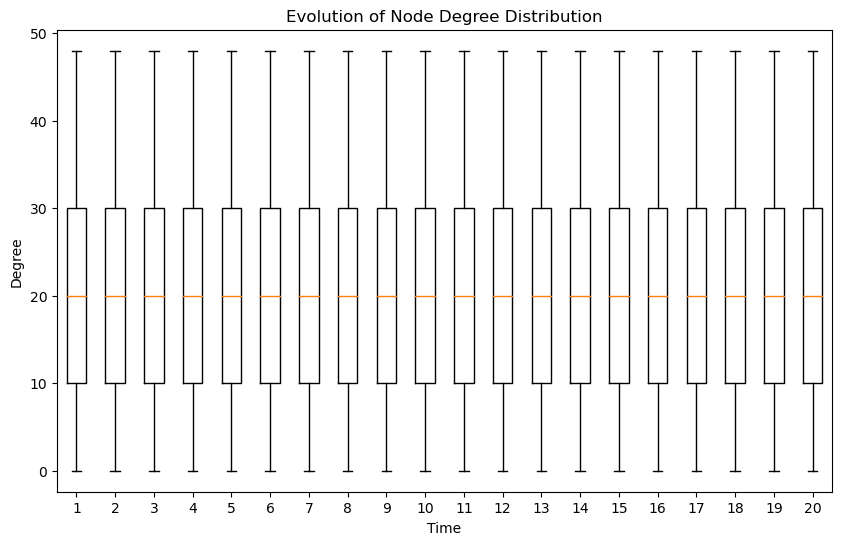

In [6]:
analyze_degree_distribution(swarm, range(0, 2000, 100))

### distributions des noeuds et avec connections

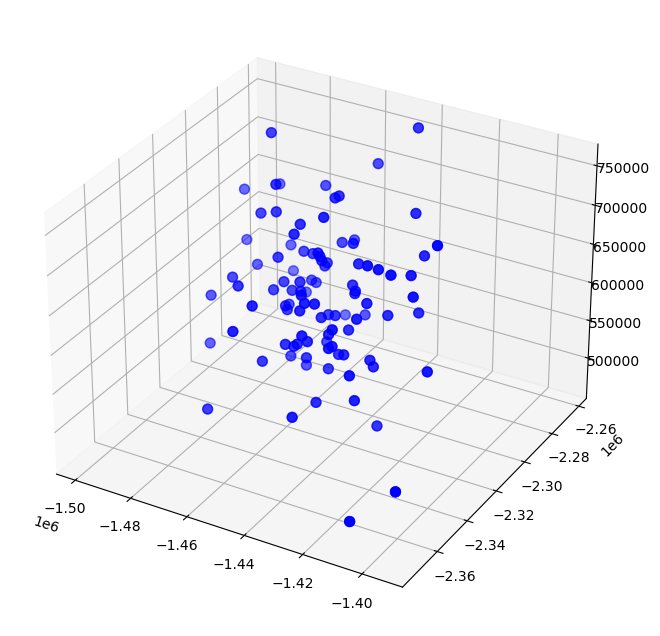

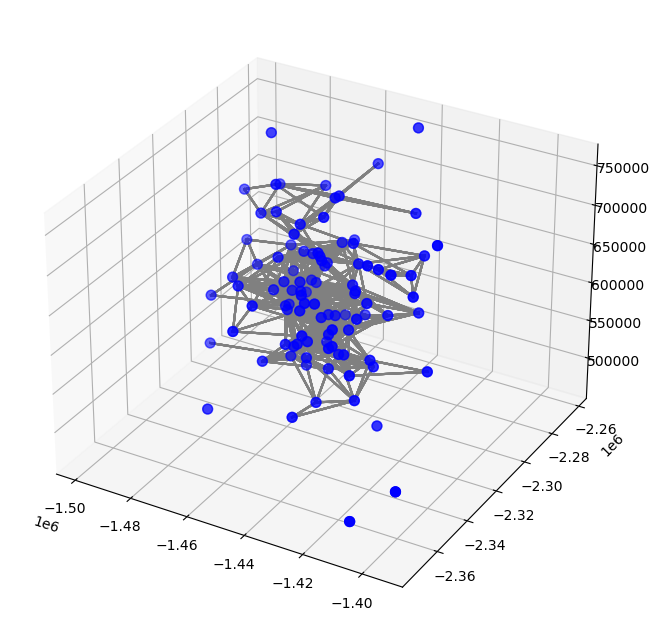

In [7]:
# Afficher un instantané du réseau
swarm.plot_nodes()
swarm.plot_edges()

In [3]:
def analyze_connectivity(swarm, timesteps):
    component_sizes = []
    backbone_sizes = []
    
    for t in timesteps:
        components = swarm.connected_components()
        component_sizes.append([len(c) for c in components])
        
        # Identification du backbone (composante permanente)
        if t > 0:
            common_nodes = set(components[0]).intersection(prev_components[0])
            backbone_sizes.append(len(common_nodes))
        prev_components = components
    
    # Visualisation
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hist([max(sizes) for sizes in component_sizes], bins=20)
    plt.title("Distribution of Largest Component Size")
    
    plt.subplot(1,2,2)
    plt.plot(backbone_sizes)
    plt.title("Backbone Size Evolution (Like Paper P3)")
    plt.show()

In [ ]:
def analyze_inter_contact_times(swarm, timesteps):
    contact_matrix = np.zeros((len(swarm.nodes), len(swarm.nodes)))
    last_contact = np.full((len(swarm.nodes), len(swarm.nodes)), -np.inf)
    inter_contacts = []
    
    for t in timesteps:
        for i, node1 in enumerate(swarm.nodes):
            for j, node2 in enumerate(swarm.nodes):
                if i != j and node1.compute_dist(node2) <= swarm.connection_range:
                    if last_contact[i,j] > 0:
                        inter_contacts.append(t - last_contact[i,j])
                    last_contact[i,j] = t
    
    # Analyse de disponibilité comme dans P3 du papier
    availability = len(inter_contacts) / (len(swarm.nodes)**2 * len(timesteps))
    print(f"Average link availability: {availability:.2%} (Paper mentions <25%)")
    
    plt.figure(figsize=(10,6))
    plt.hist(inter_contacts, bins=50)
    plt.title("Inter-Contact Time Distribution (Critical for Routing)")
    plt.xlabel("Time steps between contacts")
    plt.ylabel("Frequency")
    plt.show()
    

In [9]:
# Paramètres comme dans le papier
TIMESTEPS = range(0, 2000, 10)  # Analyse tous les 10 pas de temps
CONNECTION_RANGE = 30000 


# Exécution des analyses
#analyze_degree_distribution(swarm, TIMESTEPS)
#analyze_connectivity(swarm, TIMESTEPS)
#analyze_inter_contact_times(swarm, TIMESTEPS)

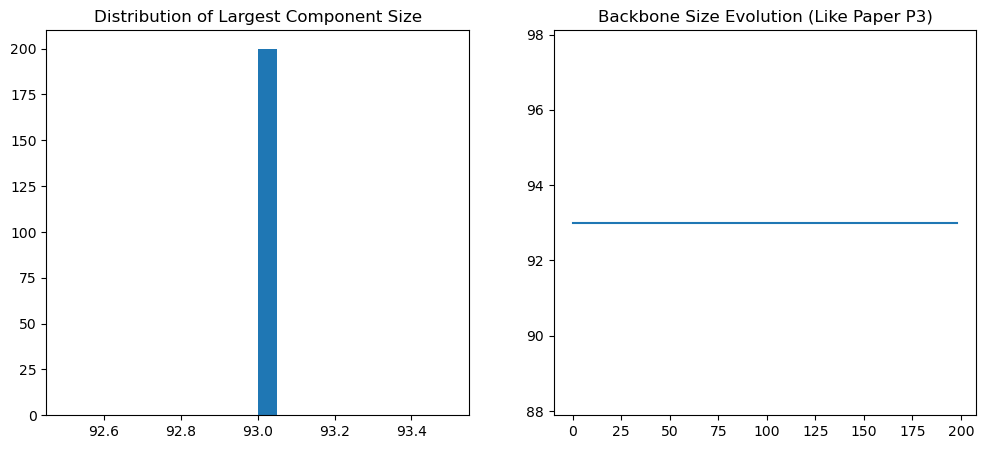

In [12]:
analyze_connectivity(swarm, TIMESTEPS)
#analyze_inter_contact_times(swarm, TIMESTEPS)